In [1]:
import pandas as pd
import numpy as np
#graphe , correlation
import matplotlib.pyplot as plt
import seaborn as sns
## KNNImputer pour la correlation , remplace les valeurs nulles
from sklearn.impute import KNNImputer

# User Story 1 : Chargement et Analyse exploratoire des données (EDA)

<span style="color:#007ACC; font-weight:bold">
Importer les données à l’aide de pandas.  
Comprendre la structure générale du jeu de données (types, dimensions, aperçus).
</span>



In [2]:

df = pd.read_csv("dataset-diabete.csv")   
df.head()   


,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0,6,148,72,35,0,33.6,0.627,50
1,1,1,85,66,29,0,26.6,0.351,31
2,2,8,183,64,0,0,23.3,0.672,32
3,3,1,89,66,23,94,28.1,0.167,21
4,4,0,137,40,35,168,43.1,2.288,33


In [3]:
df.describe()

,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,383.500000,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,221.846794,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,191.750000,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,383.500000,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,575.250000,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,767.000000,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


<span style="color:#007ACC; font-weight:bold">Identifier les valeurs manquantes et les doublons.</span>  

Après la description des données, on remarque qu’il y a des valeurs égales à 0 pour certaines features qui, logiquement, ne peuvent pas avoir de valeur 0.  
Nous allons donc considérer ces valeurs comme des valeurs nulles et manquantes.
<ul>
<li>1 _ on remplace les 0 par NA</li>
<li>2 _ on supprime les doublons</li>
<li>3 _ on compte les valeurs manquantes</li>
</ul>


In [4]:
# Colonnes où 0 n'est pas valide
cols_to_fix = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
# Remplacer les 0 par NaN
df[cols_to_fix] = df[cols_to_fix].replace(0, pd.NA)


# supprimer les doublons
    # Afficher le nombre de doublons avant suppression
print("Nombre de doublons avant :", df.duplicated().sum())
    # Supprimer les doublons
df = df.drop_duplicates()
    # Vérifier après suppression
print("Nombre de doublons après :", df.duplicated().sum())


# compter les valeurs manquantes
print("Somme des valeurs null : \n" ,df.isnull().sum())

Nombre de doublons avant : 0
Nombre de doublons après : 0
Somme des valeurs null : 
 Unnamed: 0                    0
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


Analyser la distribution des variables numériques.


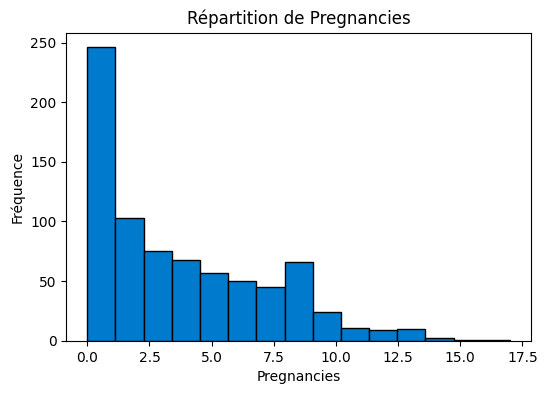

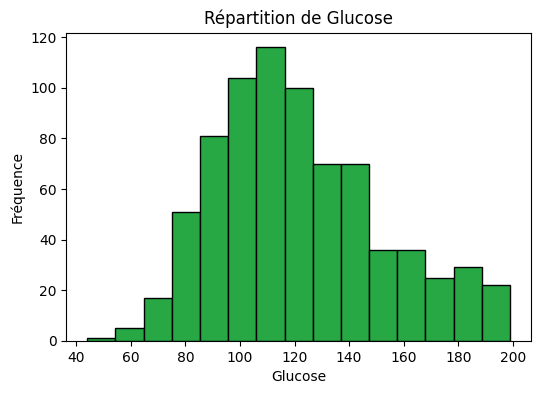

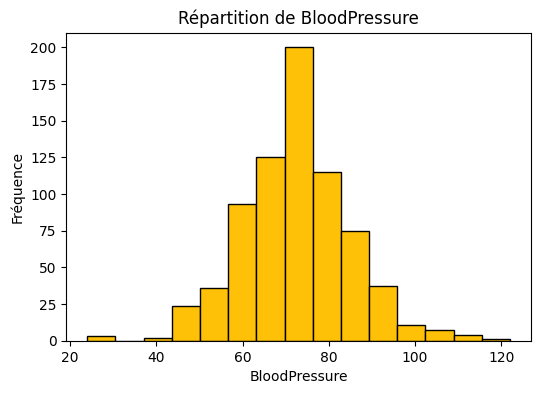

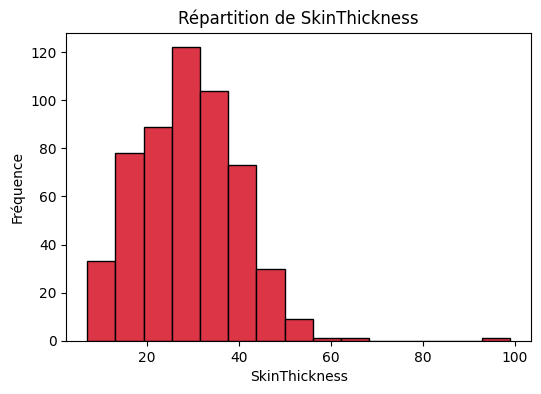

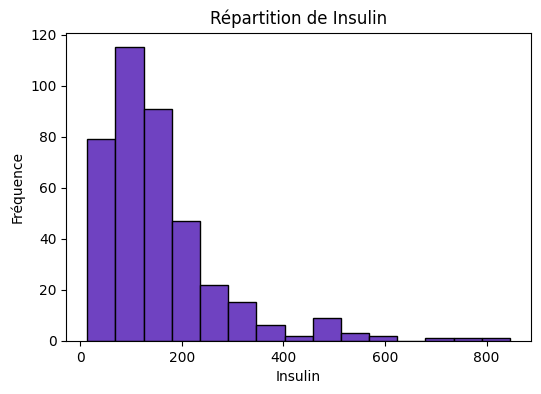

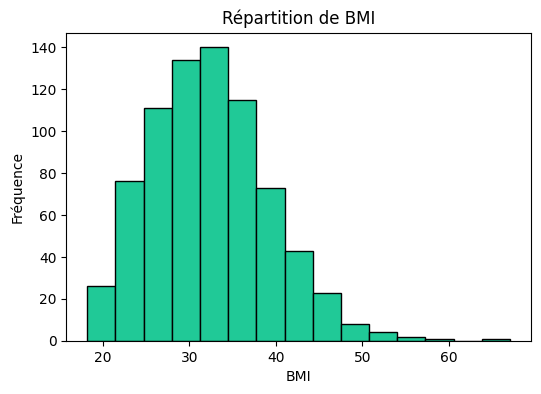

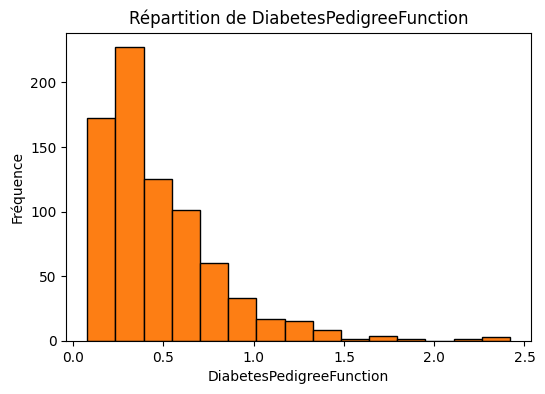

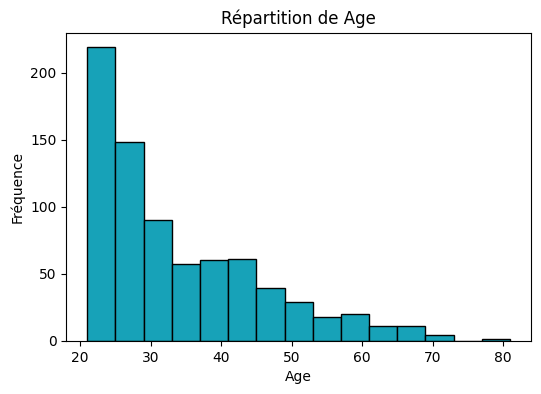

In [5]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.hist(df["Age"], bins=20, color="skyblue", edgecolor="black")
# plt.title("Répartition de l'âge")
# plt.xlabel("Âge")
# plt.ylabel("Fréquence")
# plt.show()


numeric_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]
colors = ["#007ACC", "#28A745", "#FFC107", "#DC3545", "#6F42C1", "#20C997", "#FD7E14", "#17A2B8"]

for i, col in enumerate(numeric_cols):
    plt.figure(figsize=(6,4))
    plt.hist(df[col].dropna(), bins=15, color=colors[i], edgecolor="black")
    plt.title(f"Répartition de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.show()



<span style="color:#007ACC; font-weight:bold"> Étudier les relations entre variables à l’aide de matrices de  corrélation et de visualisations.</span>

<span style="color:red; font-weight:bold"> on repondant au question 1 de user story 2</span>
<span style="color:#007ACC; font-weight:bold"> Identifier et traiter les valeurs manquantes dans le jeu de données si elles existent. </span>

Pour réaliser la matrice de corrélation, il est nécessaire de **remplir les valeurs manquantes** au préalable.  

Il existe plusieurs méthodes pour cela, comme l’imputation par la **moyenne** ou la **médiane**.  
Cette fois-ci, nous allons utiliser **KNNImputer (K-Nearest Neighbors)**.  

Cette méthode remplace chaque valeur manquante par une estimation basée sur les **valeurs des k voisins les plus proches**, c’est-à-dire des observations ayant des valeurs similaires ou proches dans les autres colonnes.  
Ainsi, on obtient des valeurs plus proches de la réalité que celles obtenues par moyenne ou médiane simples.  

**Contraintes et limites de KNNImputer :**  
- **Calcul intensif** : Trouver les k voisins les plus proches pour chaque valeur manquante peut être coûteux, surtout pour de grands ensembles de données.  
- **Sensible aux valeurs aberrantes** : Les outliers peuvent influencer l’imputation en biaisant la moyenne des voisins.  
- **Nécessite suffisamment de données** : Fonctionne mieux lorsqu’il y a assez d’observations pour trouver des voisins fiables. Si la proportion de valeurs manquantes est trop élevée, la méthode peut être moins efficace.


In [6]:
import pandas as pd
from sklearn.impute import KNNImputer

numeric_cols = [ "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction"]

# S'assurer que les colonnes sont numériques
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Créer l'imputer KNN
imputer = KNNImputer(n_neighbors=5)  # n_neighbors=5 par défaut

# Appliquer l'imputer
df[numeric_cols] = pd.DataFrame(imputer.fit_transform(df[numeric_cols]), columns=numeric_cols)

# Vérifier qu'il n'y a plus de valeurs manquantes
print(df[numeric_cols].isnull().sum())



Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
dtype: int64


on a traité les données on passe au correlation 

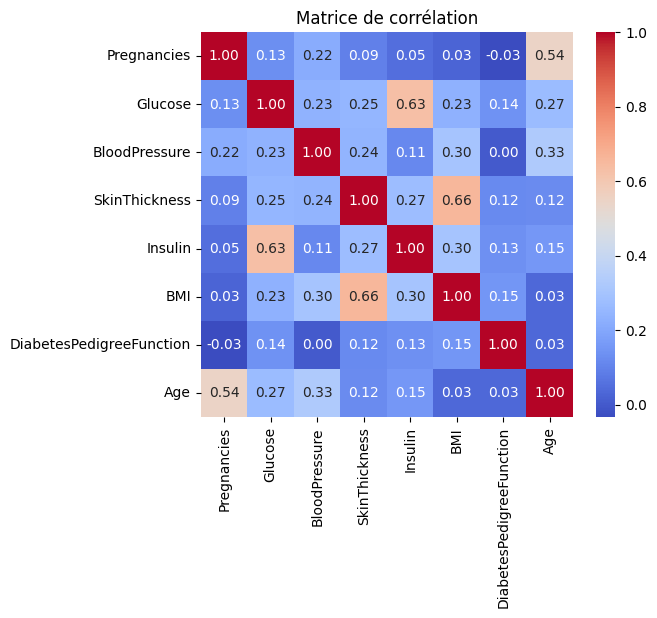

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


numeric_cols = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]

corr = df[numeric_cols].corr()


# affiche sous format matrice
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()



<span style="color:red">Analyse :</span>

** Corrélations fortes**

- **Insulin & Glucose → 0.63**  
  Les niveaux d’insuline augmentent généralement avec la glycémie. Corrélation logique biologiquement.

- **BMI & SkinThickness → 0.64**  
  Plus le BMI est élevé, plus l’épaisseur cutanée (SkinThickness) est grande, cohérent avec l’indice de masse corporelle.

- **Age & Pregnancies → 0.54**  
  Plus l’âge augmente, plus le nombre de grossesses a tendance à être élevé.


## User Story 2 : Prétraitement des données - Gestion des valeurs manquantes et aberrantes

<span style="color:#007ACC; font-weight:bold"> Identifier et traiter les valeurs manquantes dans le jeu de données si elles existent. </span>  
la reponse en haut dans la reponse de la question de correlation d user story 1

<span style="color:#007ACC; font-weight:bold">Utiliser des techniques statistiques (ex. : boîte à moustaches, z-score, IQR) pour détecter les outliers. </span>  

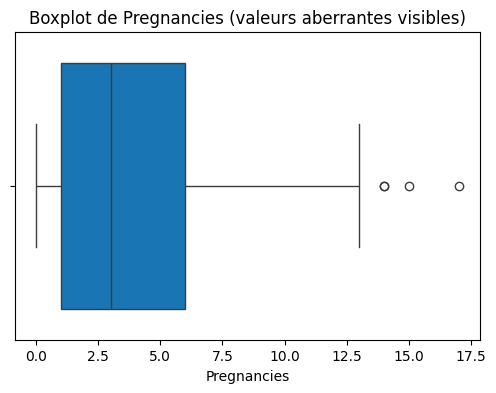

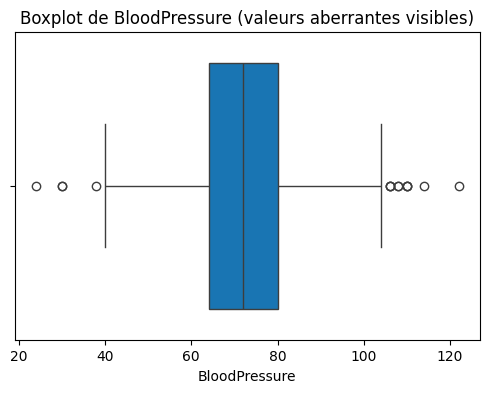

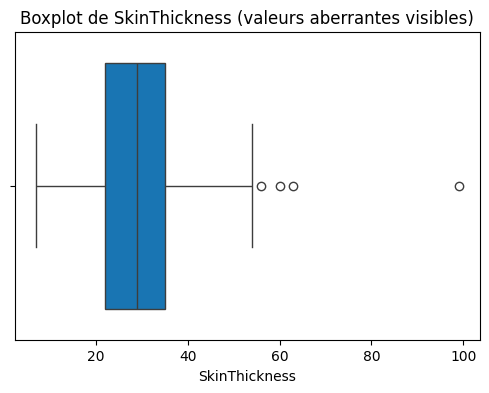

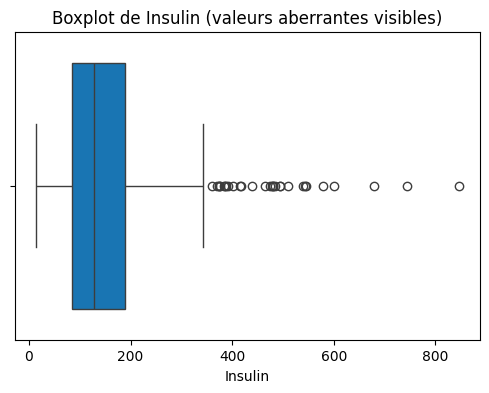

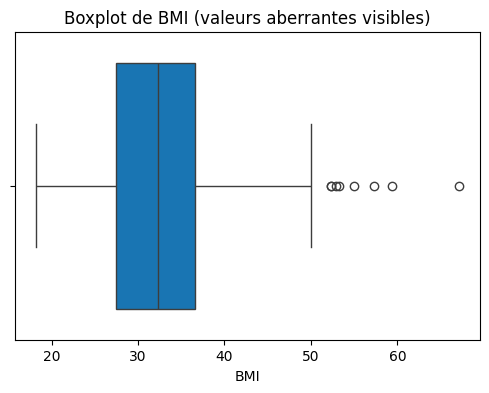

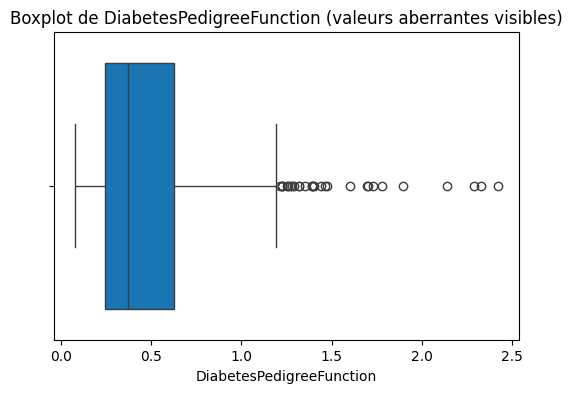

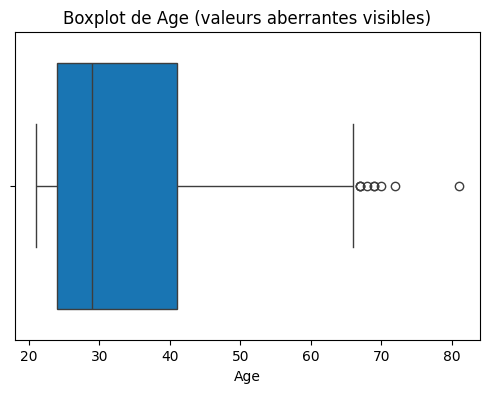

Unnamed: 0 : 0 outliers détectés
Pregnancies : 4 outliers détectés
Glucose : 0 outliers détectés
BloodPressure : 14 outliers détectés
SkinThickness : 4 outliers détectés
Insulin : 30 outliers détectés
BMI : 8 outliers détectés
DiabetesPedigreeFunction : 29 outliers détectés
Age : 9 outliers détectés


In [8]:

# Sélectionner les colonnes numériques
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Fonction pour détecter les outliers selon l'IQR
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers


# Affichage des boxplots pour chaque colonne
for col in numerical_cols:
    outliers = detect_outliers_iqr(df, col)
    if len(outliers)!= 0 :  # j affiche boite a moutache seulement pour les features avec valeur aberrante
        plt.figure(figsize=(6,4))
        sns.boxplot(x=df[col], color="#007ACC")
        plt.title(f"Boxplot de {col} (valeurs aberrantes visibles)")
        plt.show()
# Détecter les outliers pour chaque colonne numérique
for col in numerical_cols:
    outliers = detect_outliers_iqr(df, col)
    print(f"{col} : {len(outliers)} outliers détectés")


<span style="color:red">Analyse :</span> Le Z-score n’est pas pertinent dans notre cas, car il s’applique principalement à des données symétriques et suivant une distribution normale.
Nos variables ne respectant pas cette condition, il est donc préférable d’utiliser la méthode des quartiles (IQR), qui est plus robuste face aux distributions asymétriques et aux valeurs extrêmes.

<span style="color:#007ACC; font-weight:bold">Gérer les lignes contenant des valeurs aberrantes dans les colonnes pertinentes</span>
Nous allons d’abord visualiser les valeurs aberrantes afin de mieux comprendre la distribution des données et identifier si elles sont plausibles ou erronées.
Dans le contexte des valeurs aberrantes :

Une valeur est plausible si elle pourrait réellement exister.

Exemple : Pregnancies = 15 → rare, mais biologiquement possible → plausible.

Une valeur est non plausible si elle résulte probablement d’une erreur.

Exemple : BloodPressure = 300 → très improbable → non plausible.

In [12]:
import pandas as pd

# Suppose ton DataFrame s'appelle df
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Affichage des valeurs aberrantes par feature
for col in numeric_cols:
    outliers_col = df[(df[col] < lower_bound[col]) | (df[col] > upper_bound[col])]
    print(f"\n🔹 {col} → {len(outliers_col)} valeurs aberrantes détectées")
    print(outliers_col[[col]])




🔹 Unnamed: 0 → 0 valeurs aberrantes détectées
Empty DataFrame
Columns: [Unnamed: 0]
Index: []

🔹 Pregnancies → 4 valeurs aberrantes détectées
     Pregnancies
88            15
159           17
298           14
455           14

🔹 Glucose → 0 valeurs aberrantes détectées
Empty DataFrame
Columns: [Glucose]
Index: []

🔹 BloodPressure → 14 valeurs aberrantes détectées
     BloodPressure
18            30.0
43           110.0
84           108.0
106          122.0
125           30.0
177          110.0
362          108.0
549          110.0
597           24.0
599           38.0
658          106.0
662          106.0
672          106.0
691          114.0

🔹 SkinThickness → 4 valeurs aberrantes détectées
     SkinThickness
57            60.0
120           56.0
445           63.0
579           99.0

🔹 Insulin → 30 valeurs aberrantes détectées
     Insulin
2      383.2
8      543.0
13     846.0
111    495.0
153    485.0
186    495.0
220    478.0
228    744.0
231    370.0
247    680.0
248    402.0
2

In [13]:
import pandas as pd
from scipy.stats.mstats import winsorize

# Colonnes numériques
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Détection des outliers selon IQR
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Fonction pour gérer les valeurs aberrantes selon le type
def handle_outliers(df, col):
    # Cas 1 : valeurs plausibles mais extrêmes → Winsorization
    if col in ['Pregnancies', 'BMI', 'Age', 'SkinThickness']:
        df[col] = winsorize(df[col], limits=(0.01, 0.01))  # Limiter 1% min et max
    
    # Cas 2 : valeurs aberrantes probablement dues à une erreur → imputer par mediane
    elif col in ['BloodPressure', 'Insulin', 'Glucose']:
        df[col] = df[col].mask((df[col] < lower_bound[col]) | (df[col] > upper_bound[col]), df[col].median())
    
    return df

# Appliquer la fonction pour chaque colonne
for col in numeric_cols:
    df = handle_outliers(df, col)

# Vérifier les nouvelles valeurs aberrantes
for col in numeric_cols:
    outliers_col = df[(df[col] < lower_bound[col]) | (df[col] > upper_bound[col])]
    print(f"{col} : {len(outliers_col)} valeurs aberrantes restantes")


Unnamed: 0 : 0 valeurs aberrantes restantes
Pregnancies : 0 valeurs aberrantes restantes
Glucose : 0 valeurs aberrantes restantes
BloodPressure : 0 valeurs aberrantes restantes
SkinThickness : 0 valeurs aberrantes restantes
Insulin : 0 valeurs aberrantes restantes
BMI : 8 valeurs aberrantes restantes
DiabetesPedigreeFunction : 29 valeurs aberrantes restantes
Age : 9 valeurs aberrantes restantes
